In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np
import datetime
import plotly.express as px

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# Import csv
df = pd.read_csv('..//data/cleaned_pets.csv')

# Check Shape
df.shape

# Check dtypes
#df.dtypes

(32757, 50)

In [3]:
#df.head()

### Additional Data Cleaning:
Convert datatypes from object to string/datetime

In [4]:
# Convert to datetime
df['published_at'] = pd.to_datetime(df['published_at'])
df['status_changed_at'] = pd.to_datetime(df['status_changed_at'])
df['published_date'] = pd.to_datetime(df['published_date'])
df['status_change_date'] = pd.to_datetime(df['status_change_date'])

In [5]:
# Add day of week column to dataframe for status change and published 
df['status_change_dow'] = df['status_change_date'].dt.day_name()
df['status_change_hour'] = df['status_changed_at'].dt.hour

df['published_dow'] = df['published_date'].dt.day_name()
df['published_hour'] = df['published_at'].dt.hour

In [6]:
# Define function to switch dtypes to string
def string_clean(column):
    x = df[column].astype('string')
    return x

# Switch objects to strings
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = string_clean(column)

In [7]:
# Fill null values in primary color
df['colors.primary'].fillna('Unknown Color', inplace=True)

In [8]:
# Check data types
#df.dtypes

# Main Data Question: What are the key factors influencing pet adoption dynamics in Tennessee?

### Q1. Adoption Trends:
What is the trend in the number of adoptions throughout the year 2023? Are there any noticeable patterns or trends in adoption rates over this timeframe?

In [73]:
# How many animals were available at the end of 2023 vs how many were adopted in 2023?

# Subset data and create available/adopted dataframes
available = df[df['status'] == 'adoptable']
adopted = df[df['status'] == 'adopted']

# print information
print('Animal Listing Information')
print('Listed Animals:', df['id'].count())
print('Available Animals:', available['id'].count())
print('Adopted Animals:', adopted['id'].count())
print('Unique Species', df['species'].nunique())
print('Unique Breeds', df['breeds.primary'].nunique())

Animal Listing Information
Listed Animals: 32757
Available Animals: 3022
Adopted Animals: 29735
Unique Species 14
Unique Breeds 294


In [10]:
# What is the overall adoption rate for pets in 2023?

# Count # of adoptions in adopted df and df - divide adopted by all pets and multiply * 100
overall_ar = round((adopted['id'].count() / df['id'].count()) * 100, 2)

# Print adoption rate
print('Overall Average Adoption Rate:', overall_ar, '%')

Overall Average Adoption Rate: 90.77 %


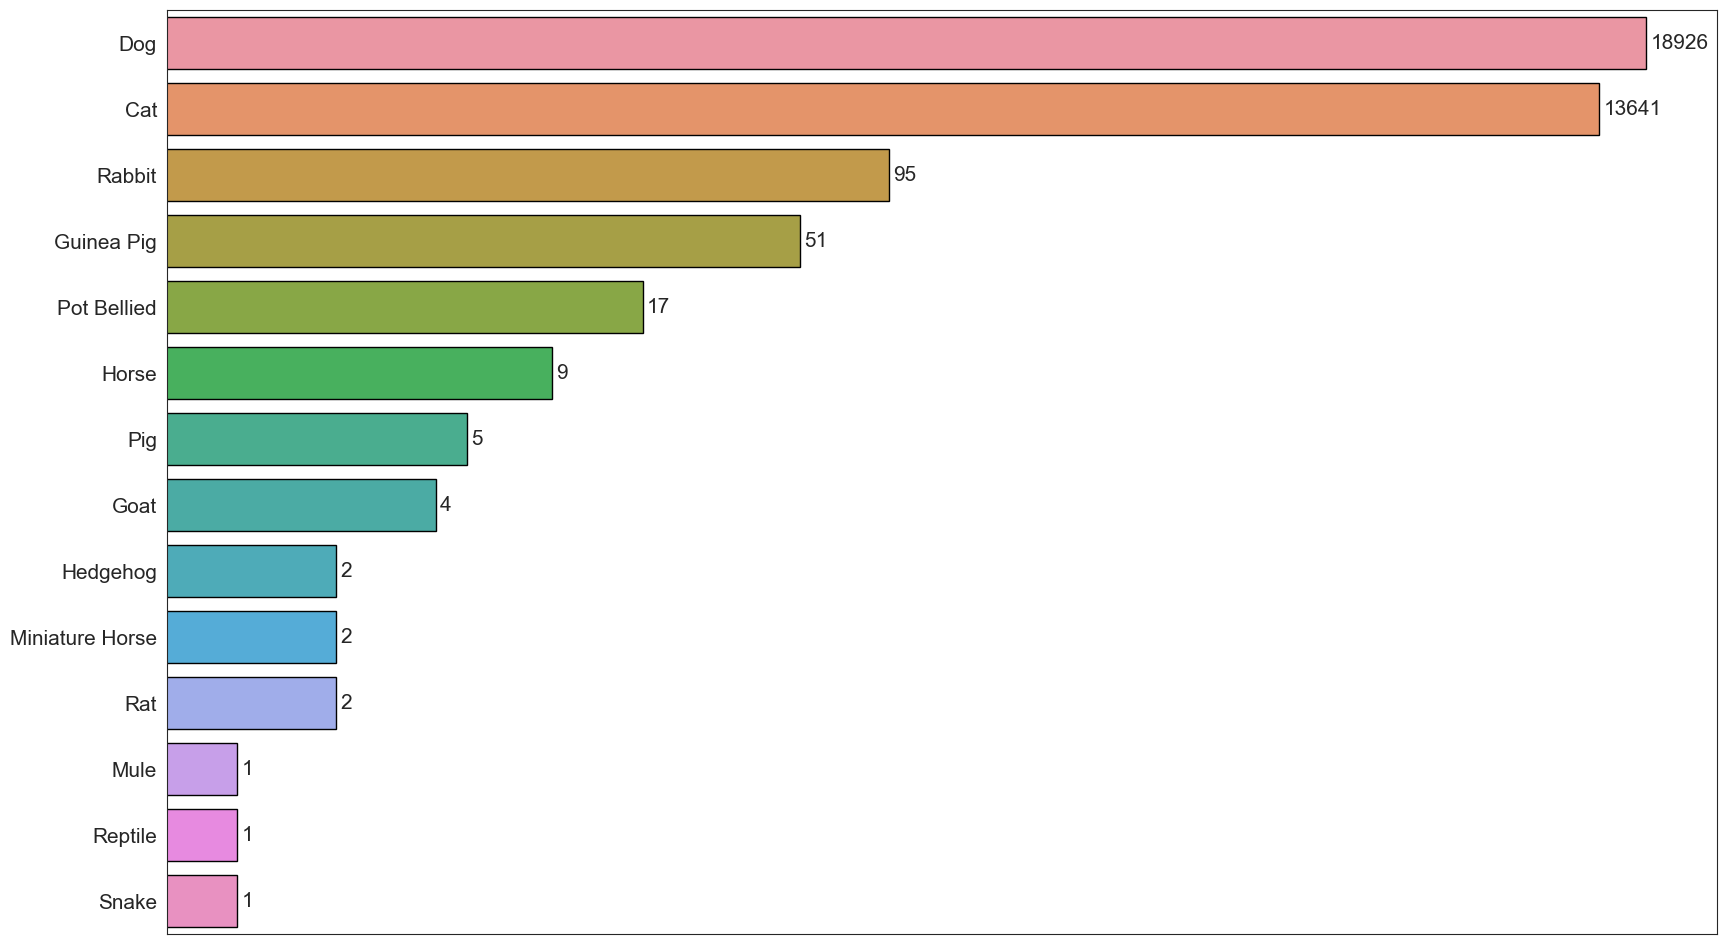

Dogs and cats are listed most frequently


In [11]:
# How many animals of each species were listed on petfinder in 2023? 
# Which animals are usually lised on petfinder?

listed = df.groupby('species')['id'].count().reset_index(name='count').sort_values('count', ascending=False)

sns.set_style("white")
plt.rc('font', size=15)

fig, ax = plt.subplots(figsize=(20, 12))

ax = sns.barplot(x='count', y='species', data=listed, edgecolor='black', ax=ax)
ax.bar_label(ax.containers[0], labels=listed['count'], padding=3)

plt.xlabel('')
plt.ylabel('')
plt.xscale('log')

plt.xticks([])

#plt.savefig("..//graphs/species_count.png") 

plt.show()

print('Dogs and cats are listed most frequently')

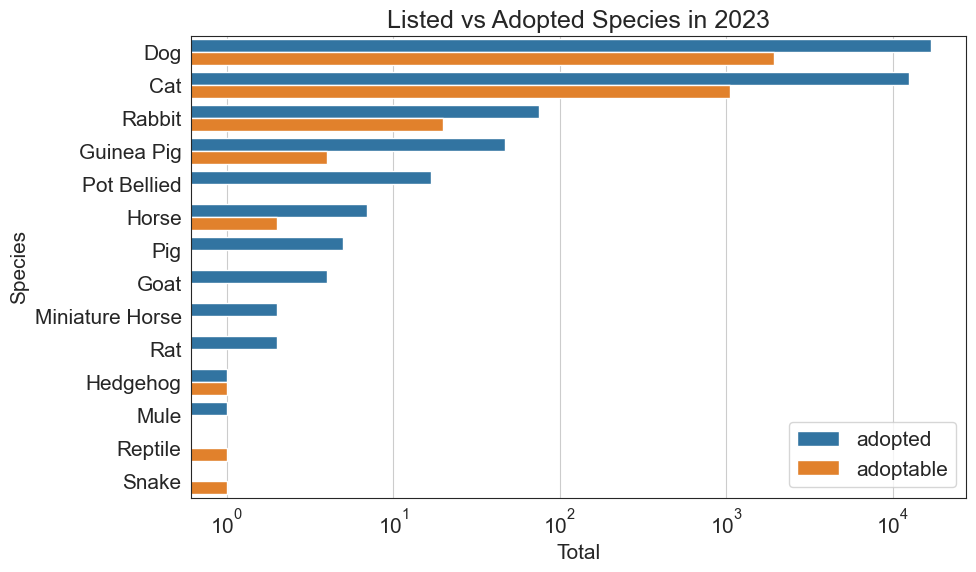

In [12]:
# What types of animal species are available for adoption vs how many were adopted in 2023? What types of animals are listed the most frequently?

listed_vs_adopted = df.groupby(['species', 'status'])['id'].count().reset_index(name='count').sort_values('count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='species', data=listed_vs_adopted, hue='status')
plt.title('Listed vs Adopted Species in 2023')
plt.xlabel('Total')
plt.ylabel('Species')
plt.xscale('log')
plt.grid(axis='x')
plt.legend(loc='lower right')

plt.show()

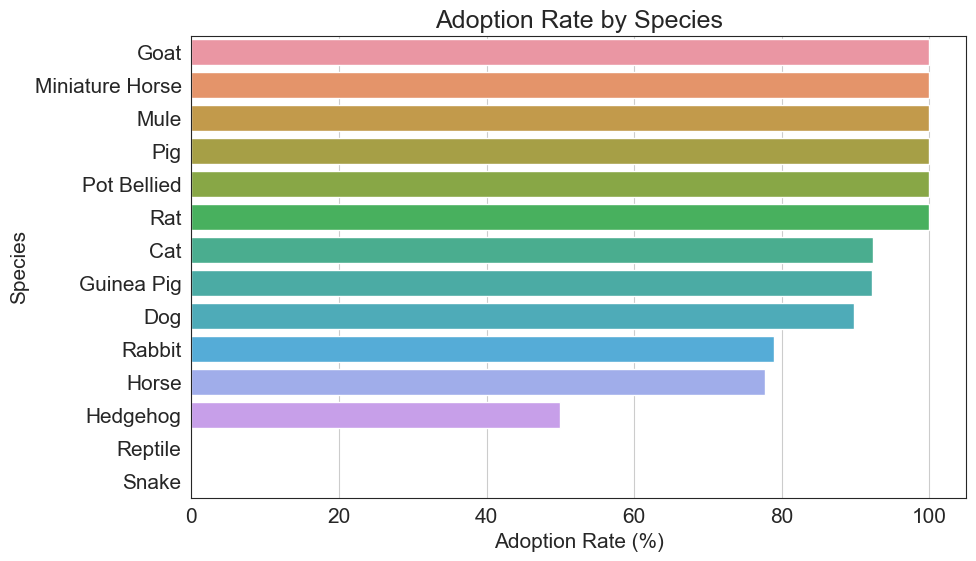

In [13]:
# What is the adoption rate by species?
# Which animals have the highest adoption rate out o the most frequently listed?

# Group and count for adopted and total
total_by_species = df.groupby('species')['id'].count().reset_index(name='count_total')
adopted_by_species = adopted.groupby('species')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
species_ar = pd.merge(total_by_species, adopted_by_species, on='species', how='outer')

# Fill NaNs
species_ar['count_adopted'] = species_ar['count_adopted'].fillna(0)

# Add new column and calculate adoption rate + round
species_ar['adoption rate %'] = round((species_ar['count_adopted'] / species_ar['count_total']) * 100, 2)
species_ar = species_ar.sort_values('adoption rate %', ascending=False)



# Plot in barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='species', data=species_ar)
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Species')
plt.title('Adoption Rate by Species')
plt.grid(axis='x')

plt.show()

#Note: Cats have a higher adoption rate than dogs

## Q2. Adoption Trends
How did the number of adoptions change over the course of 2023? Are there any noticeable patterns or trends in adoption rates?

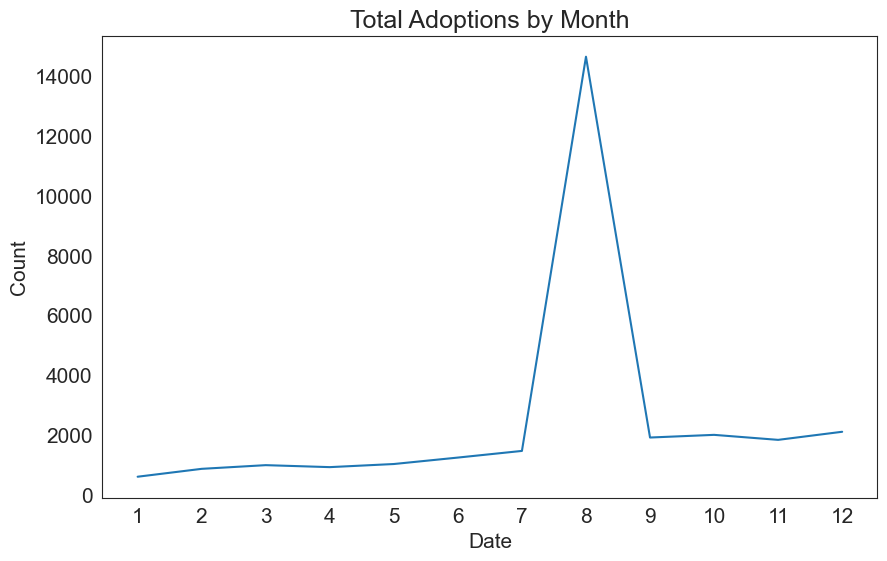

Adoptions slightly increase as the year goes on, but peak in August
Adoptions data is not accurate due to organization updates
Further investigation shows that the spike came from one specific organization on Aug 29th. 8,432 animals were listed for adoption and 8,422 were adopted from Greeneville. This was most likely due to a delay in updating the system.


In [14]:
# Group animal ids by adoption month
monthly_adoptions = adopted.groupby('month_status_change')['id'].count().reset_index(name='count')

#monthly_adoptions['status_change_date'] = pd.to_datetime(date_adoptions['status_change_date'])

plt.figure(figsize=(10, 6))

#sns.lineplot(x='status_change_date', y='count', data=date_adoptions)
sns.lineplot(x='month_status_change', y='count', data=monthly_adoptions)

plt.title('Total Adoptions by Month')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(range(1, 13)) 

plt.show()

print('Adoptions slightly increase as the year goes on, but peak in August')
print('Adoptions data is not accurate due to organization updates')
print('Further investigation shows that the spike came from one specific organization on Aug 29th. 8,432 animals were listed for adoption and 8,422 were adopted from Greeneville. This was most likely due to a delay in updating the system.')

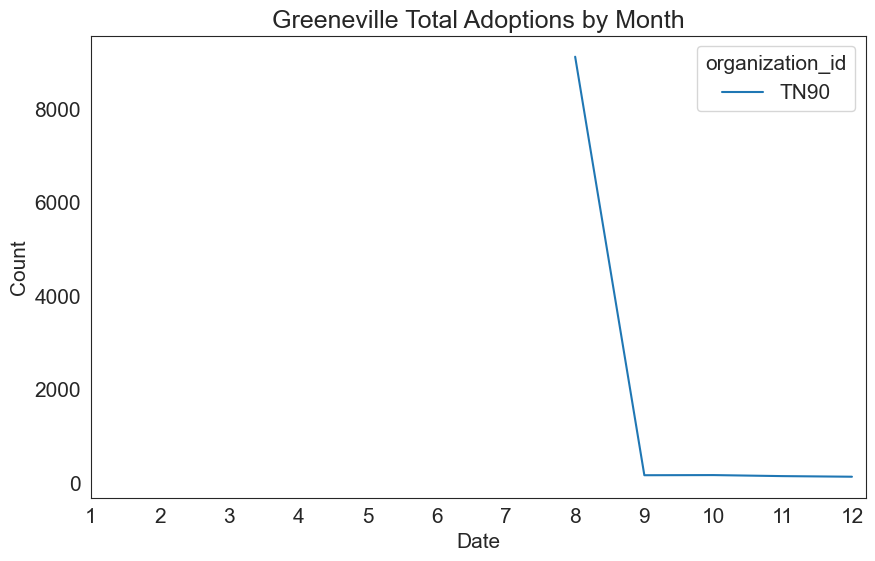

In [15]:
# Dig into data on peak

tn_90 = adopted[adopted['organization_id'] == 'TN90']

# Group animal ids by adoption month
monthly_adoptions = tn_90.groupby(['month_status_change', 'organization_id'])['id'].count().reset_index(name='count')

#monthly_adoptions['status_change_date'] = pd.to_datetime(date_adoptions['status_change_date'])

plt.figure(figsize=(10, 6))

#sns.lineplot(x='status_change_date', y='count', data=date_adoptions)
sns.lineplot(x='month_status_change', y='count', data=monthly_adoptions, hue='organization_id')

plt.title('Greeneville Total Adoptions by Month')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(range(1, 13)) 

plt.show()

### Q3. Adoption Speed:
On average, how long did it take for animals listed in 2023 to be adopted? Are there any factors (species, age, gender, size, or location) that correlate with shorter or longer adoption times?

In [16]:
# Calculate overall average adoption time 
avg_at = round(adopted['adoption_time'].mean(), 2)

print('Average Adoption Time:', avg_at, 'days')

Average Adoption Time: 16.95 days


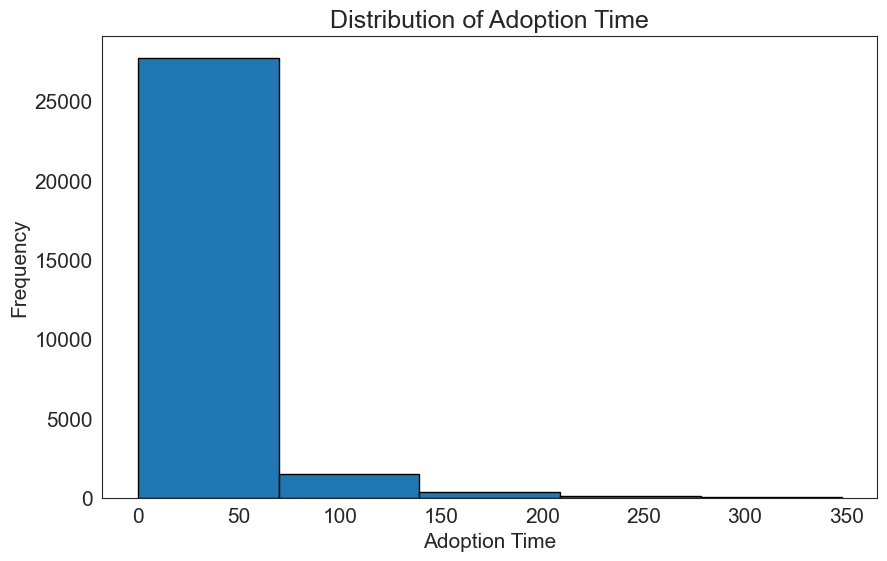

Most adoptions occur between 0-30 days, the distribution is heavily skewed towards shorter adoption times


In [17]:
# What is the distribution of adoption speed?
plt.figure(figsize=(10, 6))
plt.hist(adopted['adoption_time'], bins=5, edgecolor='black')
plt.xlabel('Adoption Time')
plt.ylabel('Frequency')
plt.title('Distribution of Adoption Time')
plt.show()

print('Most adoptions occur between 0-30 days, the distribution is heavily skewed towards shorter adoption times')


In [18]:
distribution = adopted.groupby('adoption_time')['id'].count()

distribution.to_csv('..//data/dist.csv')

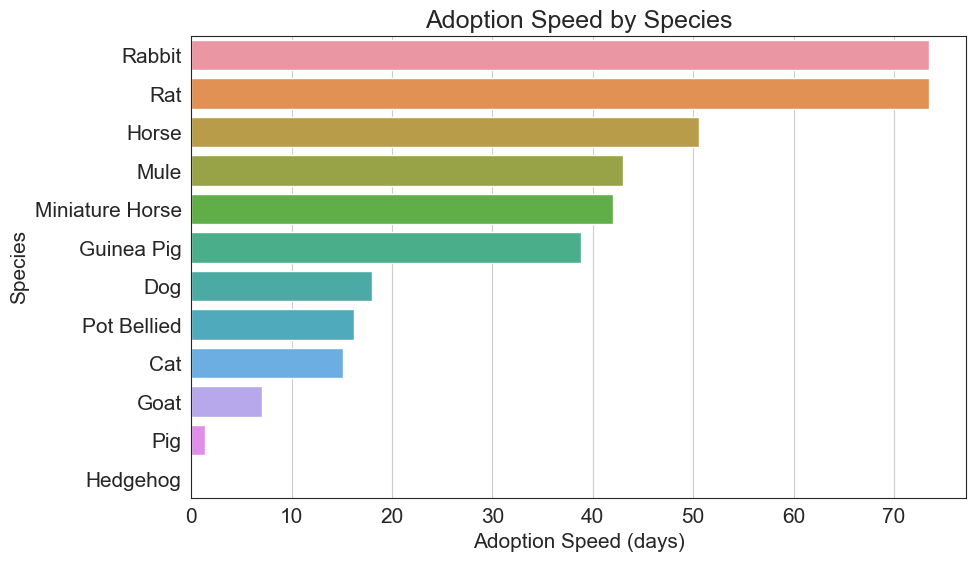

Rabbits and rats have longer adoption times > 70 days


In [19]:
# Does species type impact adoption speed? 

# Group species and calculate average adoption time
species_at = adopted.groupby('species')['adoption_time'].mean().reset_index(name='Avg Adoption Time').sort_values('Avg Adoption Time', ascending=False)
species_at['Avg Adoption Time'] = round(species_at['Avg Adoption Time'], 2) 

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Avg Adoption Time', y='species', data=species_at)
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Species')
plt.title('Adoption Speed by Species')
plt.grid(axis='x')
plt.show()

print('Rabbits and rats have longer adoption times > 70 days')

In [20]:
# Group by age, size, and gender then average adoption time
adopted.groupby(['age', 'size', 'gender'])['adoption_time'].mean()

age     size         gender
Adult   Extra Large  Female    31.171429
                     Male      16.245614
        Large        Female    21.760391
                     Male      26.061293
        Medium       Female    10.863784
                     Male       9.411325
        Small        Female     7.520408
                     Male       7.671429
Baby    Extra Large  Female    16.230769
                     Male      16.250000
        Large        Female    23.969653
                     Male      26.382812
        Medium       Female    24.529177
                     Male      24.655785
        Small        Female    22.428339
                     Male      23.682316
Senior  Extra Large  Female     3.375000
                     Male       2.523810
        Large        Female    13.656250
                     Male      13.496403
        Medium       Female    10.868167
                     Male      10.056140
        Small        Female    15.677686
                     Male    

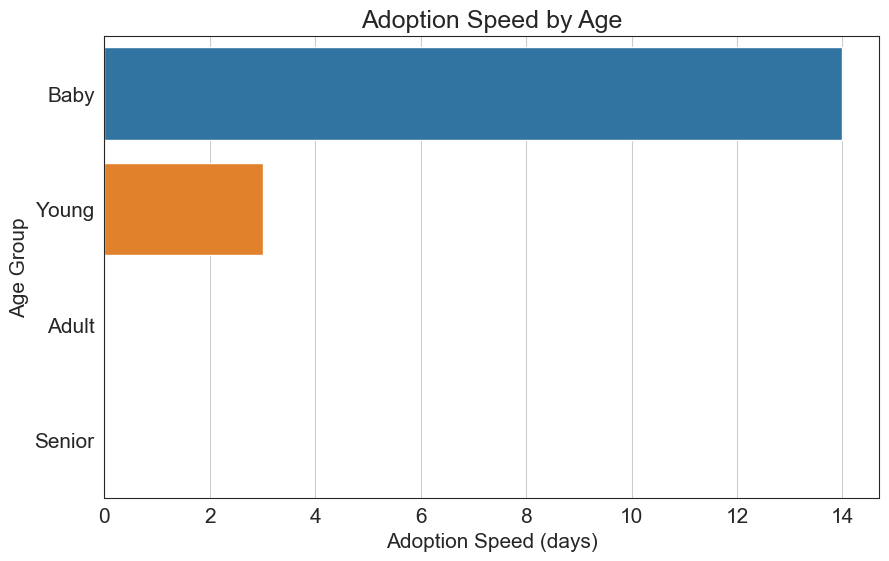

Suprisingly baby animals have a longer adoption speed than adults & seniors roughly by a couple weeks


,age,Avg Adoption Time
1,Baby,14.0
3,Young,3.0
0,Adult,0.0
2,Senior,0.0


In [21]:
# How does an animals age impact adoption speed?

# Group age and calculate average adoption time
age_at = adopted.groupby('age')['adoption_time'].median().reset_index(name='Avg Adoption Time').sort_values('Avg Adoption Time', ascending=False)
age_at['Avg Adoption Time'] = round(age_at['Avg Adoption Time'], 2) 

plt.figure(figsize=(10, 6))
sns.barplot(x='Avg Adoption Time', y='age', data=age_at)
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Age Group')
plt.title('Adoption Speed by Age')
plt.grid(axis='x')
plt.show()

print('Suprisingly baby animals have a longer adoption speed than adults & seniors roughly by a couple weeks')

age_at

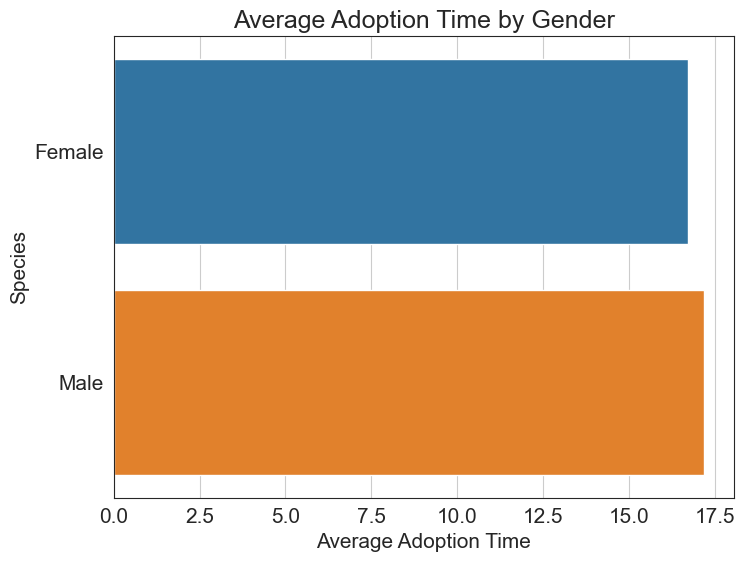

There is a slight difference in adoption time by gender by a couple days


In [22]:
# How does an animals gender impact adoption speed?

# Group by gender, calculate average adoption time
gender_at = adopted.groupby('gender')['adoption_time'].mean().reset_index(name='avg_at').sort_values('avg_at', ascending=True)

# Plot
plt.figure(figsize=(8, 6))  
sns.barplot(x='avg_at', y='gender', orient='h', data=gender_at)
plt.xlabel('Average Adoption Time')
plt.ylabel('Species')
plt.title('Average Adoption Time by Gender')
plt.grid(axis='x')
plt.show()

print('There is a slight difference in adoption time by gender by a couple days')

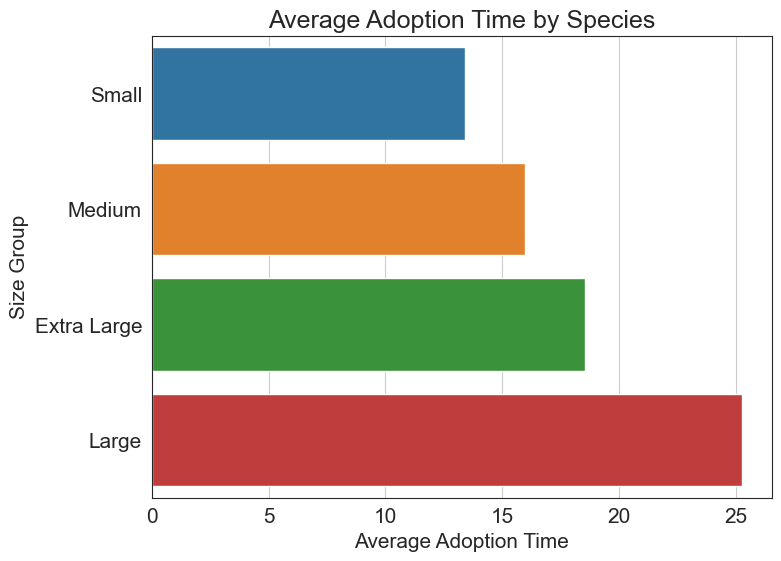

Smaller animals are adopted faster than larger animals


In [23]:
# Does an animals size impact adoption speed?

# Group by size and calculate average adoption time
size_at = adopted.groupby('size')['adoption_time'].mean().reset_index(name='avg_at').sort_values('avg_at', ascending=True)

# Plot
plt.figure(figsize=(8, 6))  
sns.barplot(x='avg_at', y='size', orient='h', data=size_at)
plt.xlabel('Average Adoption Time')
plt.ylabel('Size Group')
plt.title('Average Adoption Time by Species')
plt.grid(axis='x')
plt.show()

print('Smaller animals are adopted faster than larger animals')

In [24]:
# Does an animals location impact adoption speed - tableau

### Q3. Seasonal Trends: 
Did adoption rates or the types of animals listed vary seasonally throughout 2023? Are there certain types of animals more likely to be listed during holidays or specific times of the year?

In [25]:
# Crate function to add season
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

In [26]:
df['season'] = df['published_date'].dt.month.apply(get_season)
df.head(1)

,id,organization_id,url,type,species,age,gender,size,coat,tags,name,description,status,status_changed_at,published_at,breeds.primary,breeds.secondary,breeds.mixed,breeds.unknown,colors.primary,colors.secondary,colors.tertiary,attributes.spayed_neutered,attributes.house_trained,attributes.declawed,attributes.special_needs,attributes.shots_current,environment.children,environment.dogs,environment.cats,zip,published_date,status_change_date,adoption_time,month_published,day_published,year_published,time_published,month_status_change,day_status_change,year_status_change,time_status_change,lat,lng,city,state_name,population,density,county_name,region,status_change_dow,status_change_hour,published_dow,published_hour,season
0,70203376.0,TN90,https://www.petfinder.com/cat/ac-25055-7020337...,Cat,Cat,Young,Male,Medium,<NA>,<NA>,Ac 25055,<NA>,adopted,2023-12-31 10:03:59+00:00,2023-12-31 10:03:58+00:00,Domestic Short Hair,<NA>,False,False,Unknown Color,<NA>,<NA>,False,False,0.0,False,False,<NA>,<NA>,<NA>,37745.0,2023-12-31,2023-12-31,0.0,12.0,31.0,2023.0,10:03:58,12.0,31.0,2023.0,10:03:59,36.2784,-82.82631,Greeneville,Tennessee,20852.0,66.0,Greene,East,Sunday,10,Sunday,10,Winter


In [27]:
# Look at adoptions by month and season
adopted = df[df['status'] == 'adopted']
season_group = df.groupby(['season', 'month_status_change'])['id'].count()
season_group

season  month_status_change
Fall    9.0                     1127
        10.0                    1814
        11.0                    2045
        12.0                     900
Spring  3.0                      573
        4.0                      834
        5.0                     1078
        6.0                      659
        7.0                      280
        8.0                      175
        9.0                       92
        10.0                      95
        11.0                      47
        12.0                      38
Summer  6.0                      704
        7.0                     1372
        8.0                    14744
        9.0                      974
        10.0                     518
        11.0                     243
        12.0                     178
Winter  1.0                      695
        2.0                      944
        3.0                      520
        4.0                      197
        5.0                       94
        6.

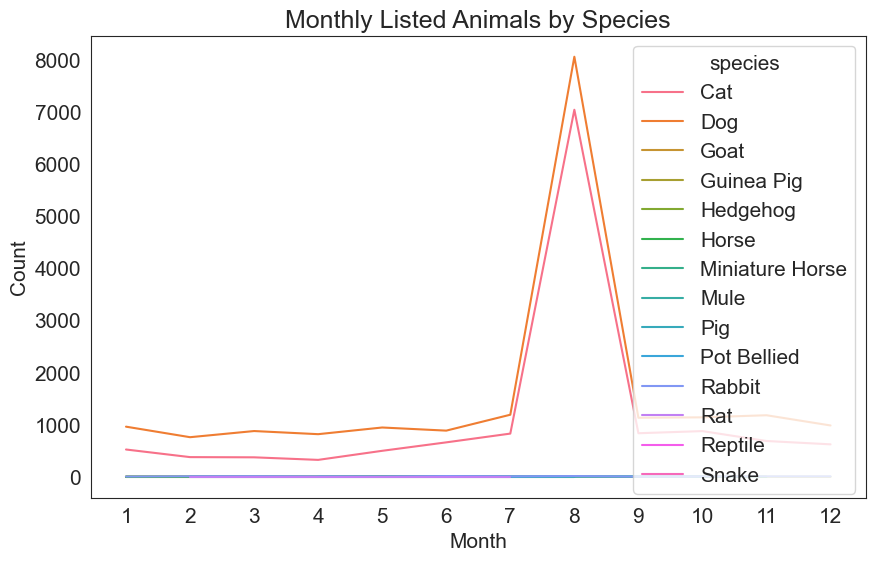

Dogs and cats are listed most frequently, however more dogs are usually listed
There is a spike in listings during summer months between July and September
This may be due to people leaving for vacation or moving away


In [28]:
# Did types of animals listed vary seasonally throughout 2023?

# Group listed by species and month, count number of species per month
monthly_listed_by_species = df.groupby(['species', 'month_published'])['id'].count().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_published', y='count', hue='species', data=monthly_listed_by_species)

plt.title('Monthly Listed Animals by Species')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(range(1, 13)) 

plt.show()

print('Dogs and cats are listed most frequently, however more dogs are usually listed')
print('There is a spike in listings during summer months between July and September')
print('This may be due to people leaving for vacation or moving away')

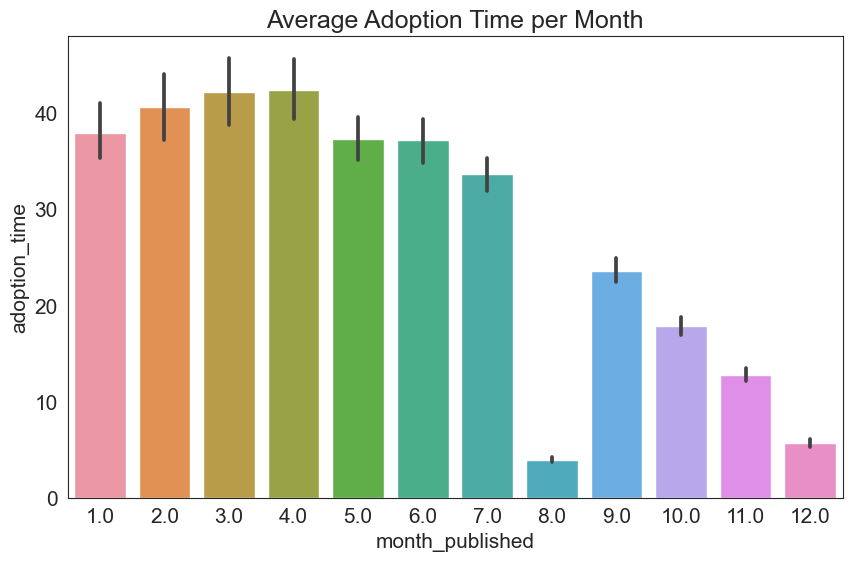

In [29]:
# What is the average speed of adoption by month?

plt.figure(figsize=(10, 6))

sns.barplot(data=adopted, x='month_published', y='adoption_time')
plt.title('Average Adoption Time per Month')
plt.show()

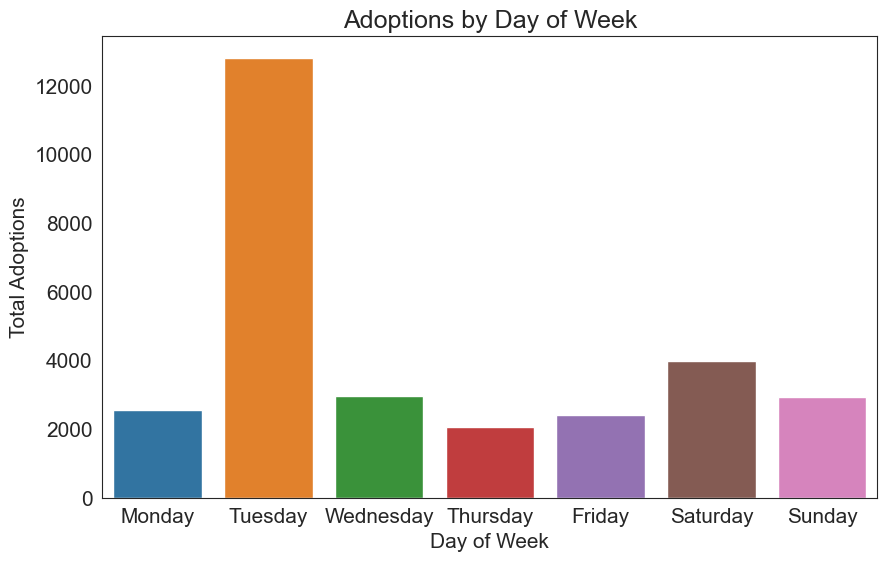

In [30]:
# Is there a specific day of the week that adoptions occur the most frequently?

order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.countplot(data=adopted, x='status_change_dow', order=order_list)
plt.title('Adoptions by Day of Week')
plt.ylabel('Total Adoptions')
plt.xlabel('Day of Week')
plt.show()

# Tuesday's seem to be the most popular day for adoptions

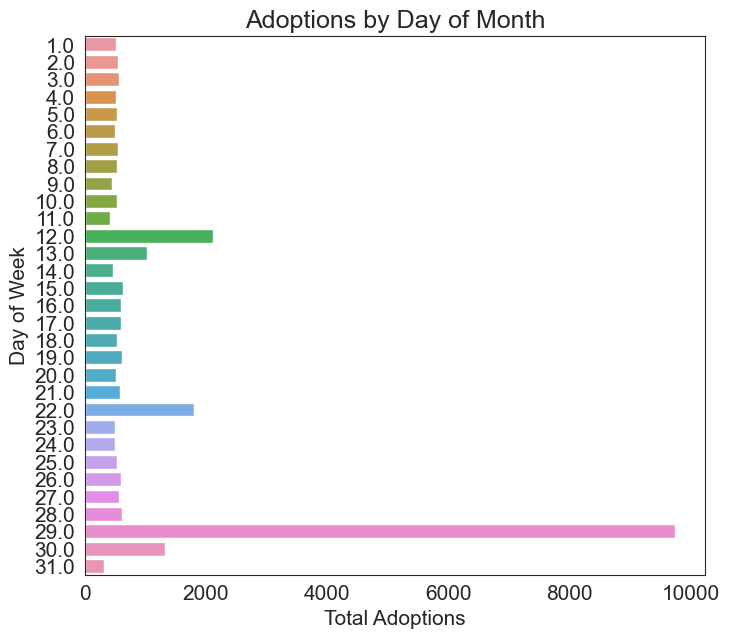

In [31]:
# Is there a trend in adoptions by day of the month?

plt.figure(figsize=(8, 7))
sns.countplot(data=adopted, y='day_status_change')
plt.title('Adoptions by Day of Month')
plt.ylabel('Day of Week')
plt.xlabel('Total Adoptions')
plt.show()

# Adoptions seem to spike towards the middle and the end of the month

In [32]:
# Why is there a spike in adoptions on the 29th of the month?

day_29 = adopted[(adopted['day_status_change'] == 29) & (adopted['status_change_dow'] == 'Tuesday')]

day_29.groupby(['status_change_dow', 'status_change_hour'])['id'].count()

# Most adoptions occured on Tuesday
# Adoption updates might be made on Tuesdays? 

status_change_dow  status_change_hour
Tuesday            0                        7
                   1                      106
                   2                       17
                   5                     5045
                   6                        1
                   8                        8
                   12                       2
                   13                       2
                   14                       2
                   16                       7
                   18                       2
                   19                    2861
                   20                       4
                   22                      10
                   23                    1188
Name: id, dtype: int64

### Q4. Breed Popularity: 
Which breeds were the most commonly listed for adoption in 2023? Which breeds were most commonly adopted? Are mixed breed animals more likely to be adopted?

In [33]:
# What are the top 10 most listed animals?
top_10_listed = df.groupby('breeds.primary')['id'].count().reset_index(name='count_listed').sort_values('count_listed', ascending=False)

# What are the top 10 most adopted?
top_10_adopted = adopted.groupby('breeds.primary')['id'].count().reset_index(name='count_adopted').sort_values('count_adopted', ascending=False)

# Merge
breeds_ar = pd.merge(top_10_listed, top_10_adopted, on='breeds.primary', how='outer')

breeds_ar.sort_values('count_listed', ascending=False).head(10)

,breeds.primary,count_listed,count_adopted
0,Domestic Short Hair,8474,7692.0
1,Domestic Medium Hair,1729,1683.0
2,Labrador Retriever,1487,1298.0
3,Unknown Mixed Breed,1107,828.0
4,Hound,1006,922.0
5,Chihuahua,1000,971.0
6,German Shepherd Dog,956,878.0
7,Terrier,934,843.0
8,Pit Bull Terrier,928,703.0
9,Domestic Long Hair,826,789.0


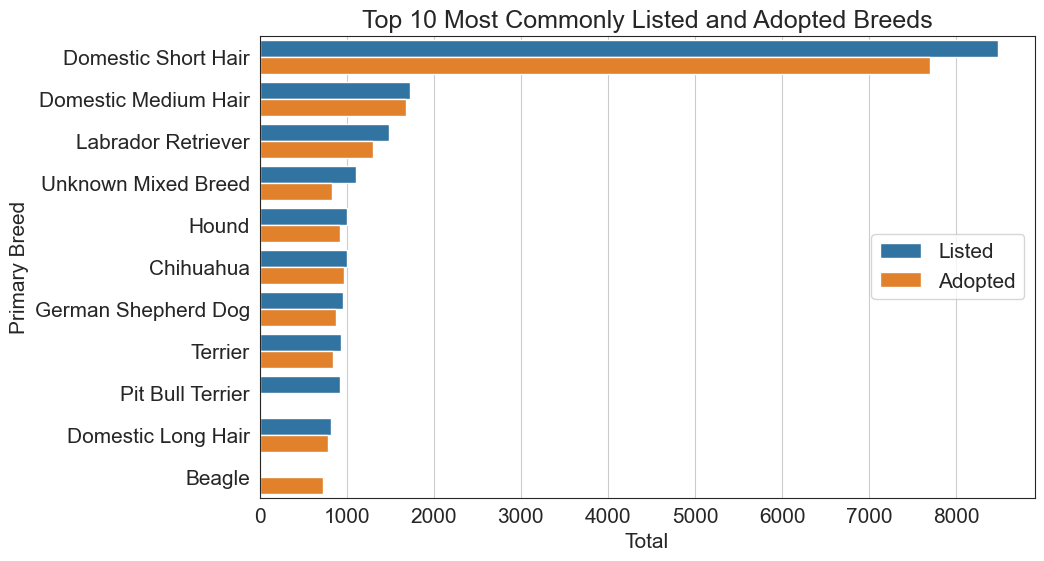

Domestic short hair cats are listed most frequently and adopted most frequently


In [34]:
# Group listed and adopted animals by primary breed and count totals
top_10_breeds = df.groupby('breeds.primary')['id'].count().reset_index(name='count').sort_values('count', ascending=False).head(10)
top_10_breeds_adopted = adopted.groupby('breeds.primary')['id'].count().reset_index(name='count').sort_values('count', ascending=False).head(10)

# Add column to identify listed vs adopted
top_10_breeds['Listed/Adopted'] = 'Listed'
top_10_breeds_adopted['Listed/Adopted'] = 'Adopted'

# Combine both dataframes into one
top_10 = pd.concat([top_10_breeds, top_10_breeds_adopted])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='breeds.primary', hue='Listed/Adopted', orient='h', data=top_10)

plt.xlabel('Total')
plt.ylabel('Primary Breed')
plt.title('Top 10 Most Commonly Listed and Adopted Breeds')
plt.legend()
plt.grid(axis='x')
plt.show()

print('Domestic short hair cats are listed most frequently and adopted most frequently')

### Q5. Animal Characteristics and Adoption: 
Are there any correlations between specific characteristics of animals (such as age, species, size, gender, or color) and their likelihood of being adopted?

In [70]:
listed_color = df.groupby(['age', 'size', 'gender'])['id'].count().reset_index(name='count_listed')
adopted_color = adopted.groupby(['age', 'size', 'gender'])['id'].count().reset_index(name='count_adopted')

char_ar = pd.merge(listed_color, adopted_color, on=['age', 'size', 'gender'], how='outer')
char_ar['Adoption Rate'] = round((char_ar['count_adopted'] / char_ar['count_listed']) * 100, 2)
char_ar.sort_values(['age'], ascending=True)

,age,size,gender,count_listed,count_adopted,Adoption Rate
0,Adult,Extra Large,Female,48,35.0,72.92
1,Adult,Extra Large,Male,121,114.0,94.21
2,Adult,Large,Female,974,818.0,83.98
3,Adult,Large,Male,1428,1191.0,83.40
4,Adult,Medium,Female,5665,5227.0,92.27
5,Adult,Medium,Male,4490,4150.0,92.43
6,Adult,Medium,Unknown,1,NaN,NaN
7,Adult,Small,Female,1742,1666.0,95.64
8,Adult,Small,Male,1609,1540.0,95.71
15,Baby,Small,Female,664,614.0,92.47


In [67]:
char_ar.to_csv('..//data/char.csv')

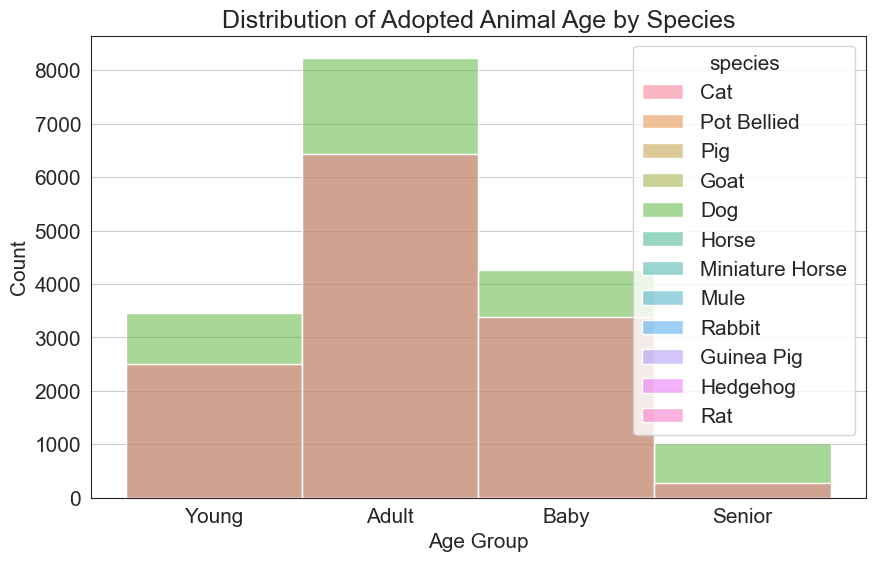

In [36]:
# What is the distribution of age among adopted animals?

plt.figure(figsize=(10, 6))
sns.histplot(data=adopted, x='age', hue='species')
plt.title('Distribution of Adopted Animal Age by Species')
plt.xlabel('Age Group')
plt.ylabel('Count')
#plt.yscale('log')
plt.grid(axis='y')

plt.show()

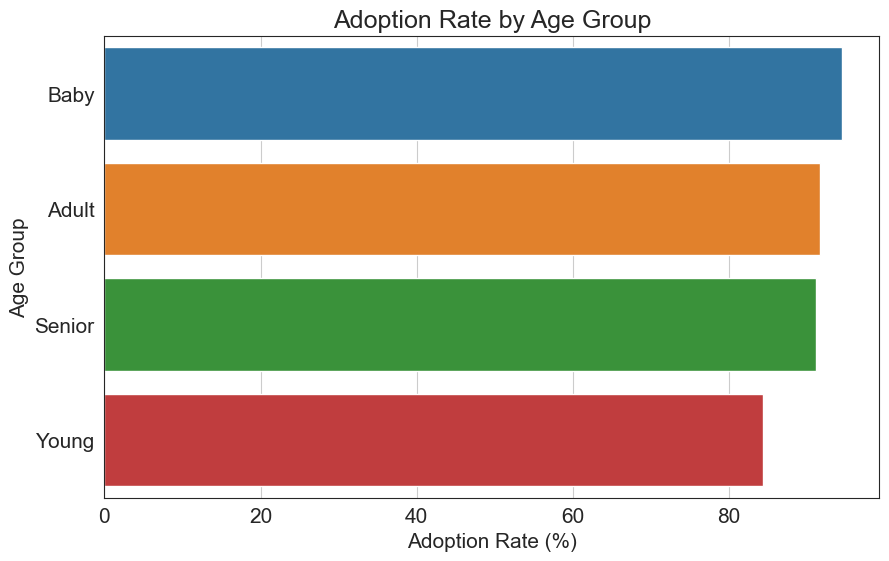

Young age group has a lower adoption rate - What is considered young vs adult?


In [37]:
# What is the adoption rate by age group? Which age groups have the highest and lowest adoption rates?

# Group and count for adopted and total
total_by_age = df.groupby('age')['id'].count().reset_index(name='count_total')
adopted_by_age = adopted.groupby('age')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
age_ar = pd.merge(total_by_age, adopted_by_age, on='age', how='outer')

# Add new column and calculate adoption rate + round
age_ar['adoption rate %'] = round((age_ar['count_adopted'] / age_ar['count_total']) * 100, 2)
age_ar = age_ar.sort_values('adoption rate %', ascending=False)

# Plot as barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='age', data=age_ar)
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Age Group')
plt.title('Adoption Rate by Age Group')
plt.grid(axis='x')
plt.show()

print('Young age group has a lower adoption rate - What is considered young vs adult?')

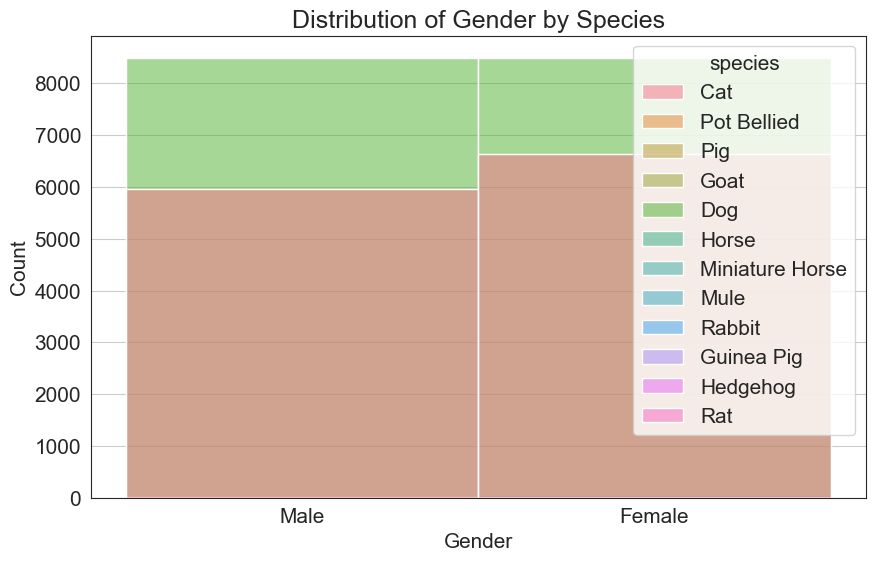

In [38]:
# What is the distribution of gender by species?

plt.figure(figsize=(10, 6))
sns.histplot(data=adopted, x='gender', hue='species')
plt.title('Distribution of Gender by Species')
plt.xlabel('Gender')
plt.ylabel('Count')
#plt.yscale('log')
plt.grid(axis='y')

plt.show()

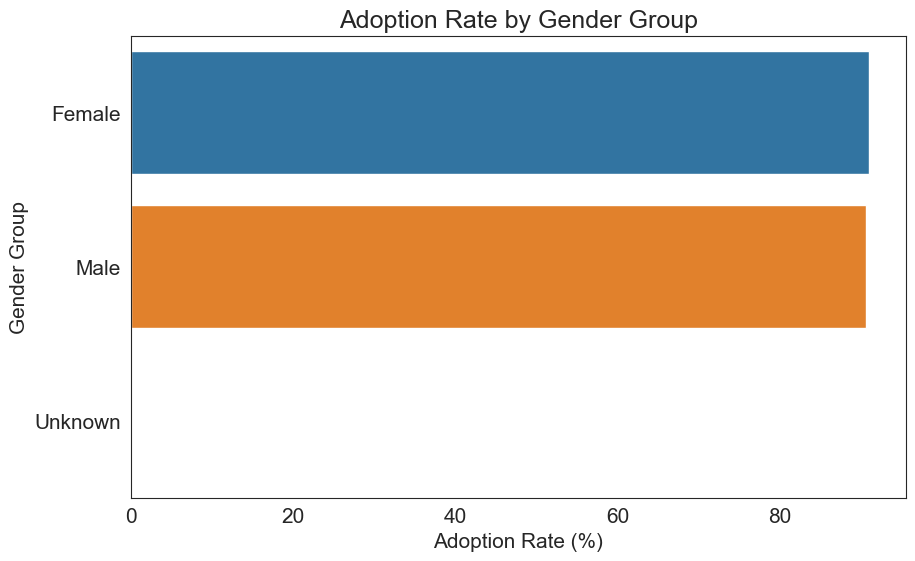

Gender does not impact adoption rate
Unknown genders are 1 reptile & 1 snake


,gender,count_total,count_adopted,adoption rate %
0,Female,16732,15221.0,90.97
1,Male,16023,14514.0,90.58
2,Unknown,2,0.0,NaN


In [39]:
# What is the adoption rate by gender group? Which gender groups have the highest and lowest adoption rates?

# Group and count for adopted and total
total_by_gender = df.groupby('gender')['id'].count().reset_index(name='count_total')
adopted_by_gender = adopted.groupby('gender')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
gender_ar = pd.merge(total_by_gender, adopted_by_gender, on='gender', how='outer')

# Add new column and calculate adoption rate + round
gender_ar['adoption rate %'] = round((gender_ar['count_adopted'] / gender_ar['count_total']) * 100, 2)

# Fill NaNs
gender_ar['count_adopted'] = gender_ar['count_adopted'].fillna(0)

gender_ar = gender_ar.sort_values('adoption rate %', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='gender', data=gender_ar)
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Gender Group')
plt.title('Adoption Rate by Gender Group')
plt.show()

#gender_ar

print('Gender does not impact adoption rate')
print('Unknown genders are 1 reptile & 1 snake')

gender_ar

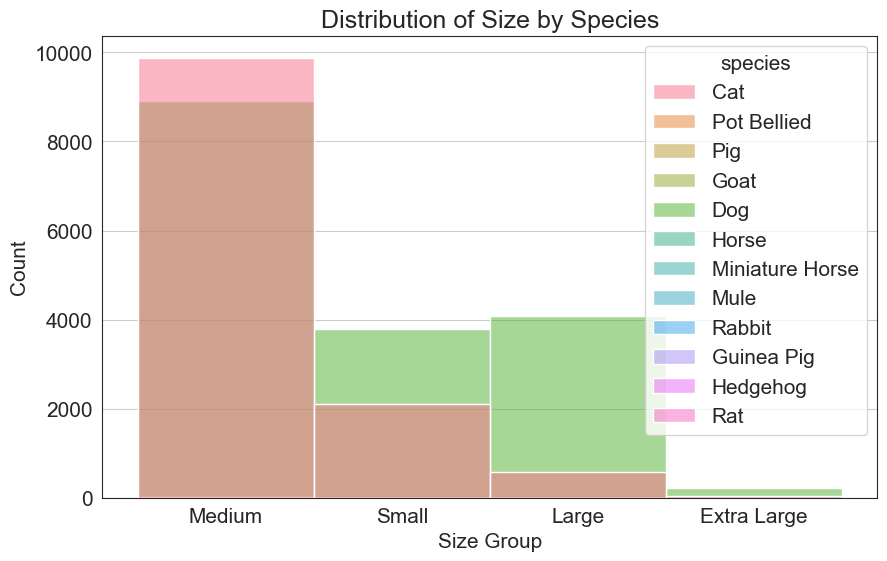

In [40]:
# What is the distribution of size group by species

plt.figure(figsize=(10, 6))
sns.histplot(data=adopted, x='size', hue='species')
plt.title('Distribution of Size by Species')
plt.xlabel('Size Group')
plt.ylabel('Count')
#plt.yscale('log')
plt.grid(axis='y')

plt.show()

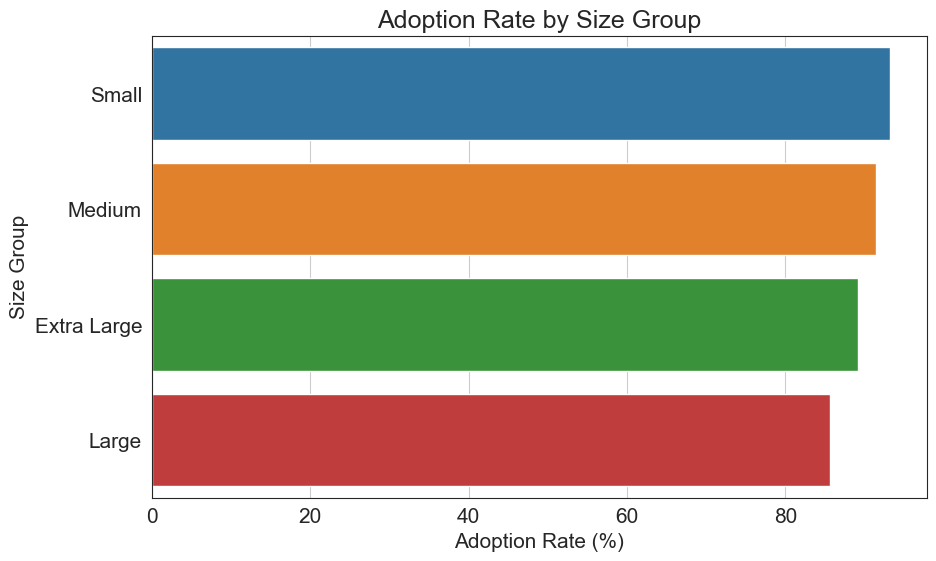

Smaller dogs are slightly more likely to be adopted


In [41]:
# What is the adoption rate by size group? Which size groups have the highest and lowest adoption rates?

# Group and count for adopted and total
total_by_size = df.groupby('size')['id'].count().reset_index(name='count_total')
adopted_by_size = adopted.groupby('size')['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
size_ar = pd.merge(total_by_size, adopted_by_size, on='size', how='outer')

# Add new column and calculate adoption rate + round
size_ar['adoption rate %'] = round((size_ar['count_adopted'] / size_ar['count_total']) * 100, 2)
size_ar = size_ar.sort_values('adoption rate %', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='adoption rate %', y='size', data=size_ar)
plt.xlabel('Adoption Rate (%)')
plt.ylabel('Size Group')
plt.title('Adoption Rate by Size Group')
plt.grid(axis='x')
plt.show()

#size_ar

print('Smaller dogs are slightly more likely to be adopted')

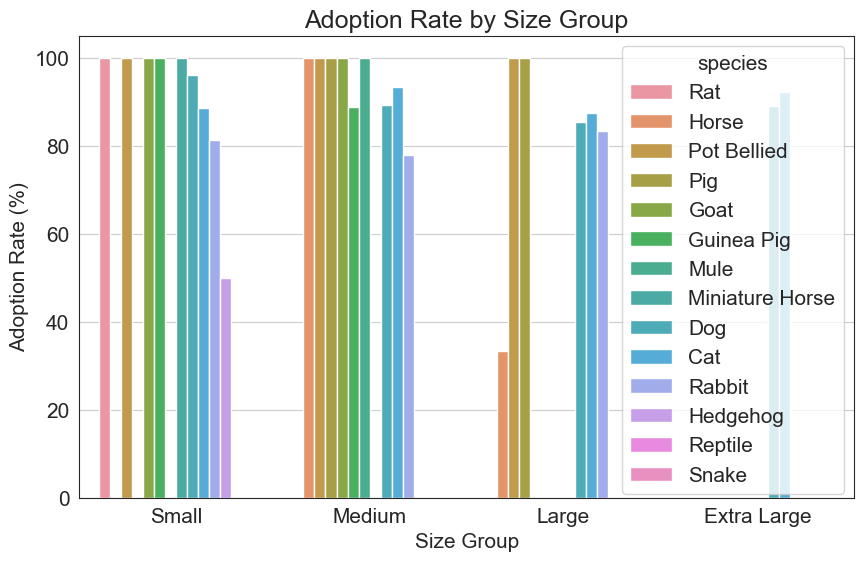

In [42]:
# What is the adoption rate by size group? Which size groups have the highest and lowest adoption rates?

# Group and count for adopted and total
total_by_size = df.groupby(['species', 'size'])['id'].count().reset_index(name='count_total')
adopted_by_size = adopted.groupby(['species', 'size'])['id'].count().reset_index(name='count_adopted')

# Merge two dataframes together
size_ar = pd.merge(total_by_size, adopted_by_size, on=(['species', 'size']), how='outer')

# Add new column and calculate adoption rate + round
size_ar['adoption rate %'] = round((size_ar['count_adopted'] / size_ar['count_total']) * 100, 2)
size_ar = size_ar.sort_values('adoption rate %', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='adoption rate %', x='size', data=size_ar, hue='species')
plt.xlabel('Size Group')
plt.ylabel('Adoption Rate (%)')
plt.title('Adoption Rate by Size Group')
plt.grid(axis='y')
plt.show()

### Q6. Special Needs Animals: 
How do animals who have special needs fare in terms of adoption rates and adoption speed compared to other animals?

In [43]:
df[['attributes.special_needs']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32757 entries, 0 to 32756
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   attributes.special_needs  32757 non-null  bool 
dtypes: bool(1)
memory usage: 32.1 KB


In [44]:
# What percentage of all animals listed are special needs? 
sn_perc = round((df[df['attributes.special_needs'] == True]['id'].count() / df['id'].count()) * 100, 2)
print('Special Needs Listed:', sn_perc, '%')

Special Needs Listed: 1.36 %


In [45]:
# What percentage of special needs animals are adopted out of the special needs animals posted?

adopted_sn_perc = round((adopted[adopted['attributes.special_needs'] == True]['id'].count() / df[df['attributes.special_needs'] == True]['id'].count()) * 100, 2)

print('Special Needs Adoption Rate:', adopted_sn_perc, '%')

Special Needs Adoption Rate: 77.13 %


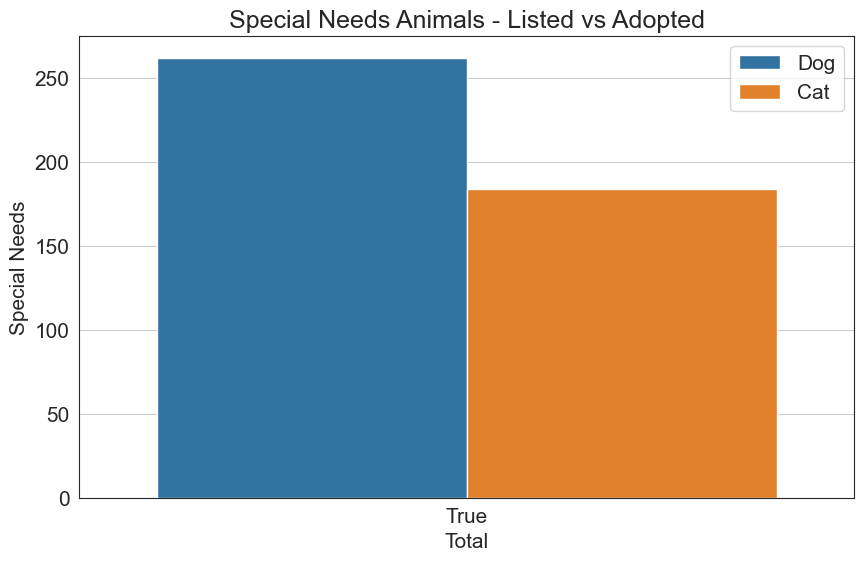

Dogs and cats are the only species listed with special needs
262 Dogs, 184 Cats


In [46]:
# How many animals of each species are special needs?

# Group listed and adopted animals by primary breed and count totals
sn = df[df['attributes.special_needs'] == True].groupby(['species', 'attributes.special_needs'])['id'].count().reset_index(name='count').sort_values('count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(y='count', x='attributes.special_needs', hue='species', data=sn)

plt.xlabel('Total')
plt.ylabel('Special Needs')
plt.title('Special Needs Animals - Listed vs Adopted')
plt.legend()
plt.grid(axis='y')
plt.show()

print('Dogs and cats are the only species listed with special needs')
print('262 Dogs, 184 Cats')

What is the average speed of adoption for special needs animals?

In [47]:
# What is the average adoption speed for special needs animals?

sn_as = round((adopted[adopted['attributes.special_needs'] == True]['adoption_time'].mean()), 2)
print('Special Needs Avg Adoption Speed:', sn_as, 'days')

Special Needs Avg Adoption Speed: 48.26 days


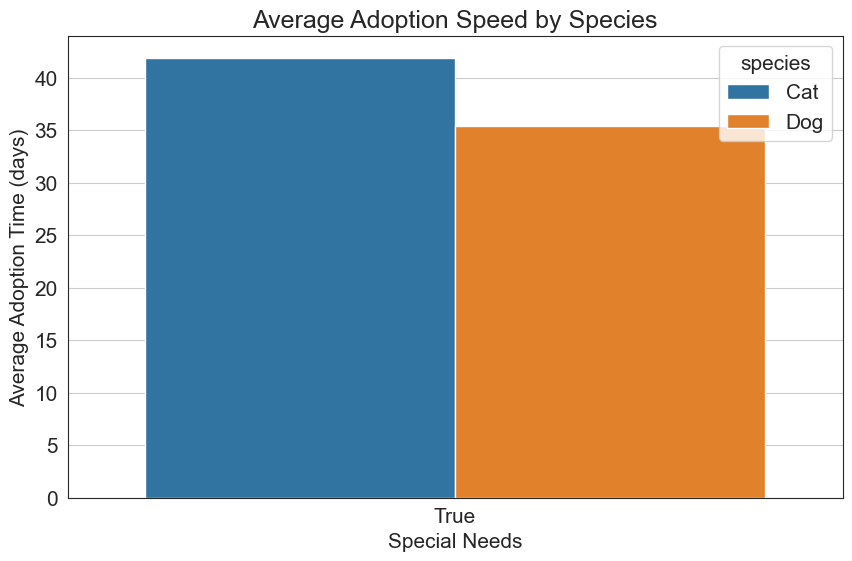

Cats with special needs tend to have a longer adoption time
Cats - 42 Days, Dogs - 35 Days


In [48]:
# What is the average adoption time by species for animals with special needs? Which species has the longest adoption speed?

special_needs = df[df['attributes.special_needs'] == True]

avg_at = special_needs.groupby(['species', 'attributes.special_needs'])['adoption_time'].mean().reset_index(name='avg_at')

plt.figure(figsize=(10, 6))
sns.barplot(x='attributes.special_needs', y='avg_at', data=avg_at, hue='species')
plt.xlabel('Special Needs')
plt.ylabel('Average Adoption Time (days)')
plt.title('Average Adoption Speed by Species')
plt.grid(axis='y')
plt.show()

print('Cats with special needs tend to have a longer adoption time')
print('Cats - 42 Days, Dogs - 35 Days')
#avg_at

### Q7. Geographic Analysis: 
Are there geographic patterns in adoption rates or the types of animals listed for adoption? Are certain regions more likely to list certain types of animals?

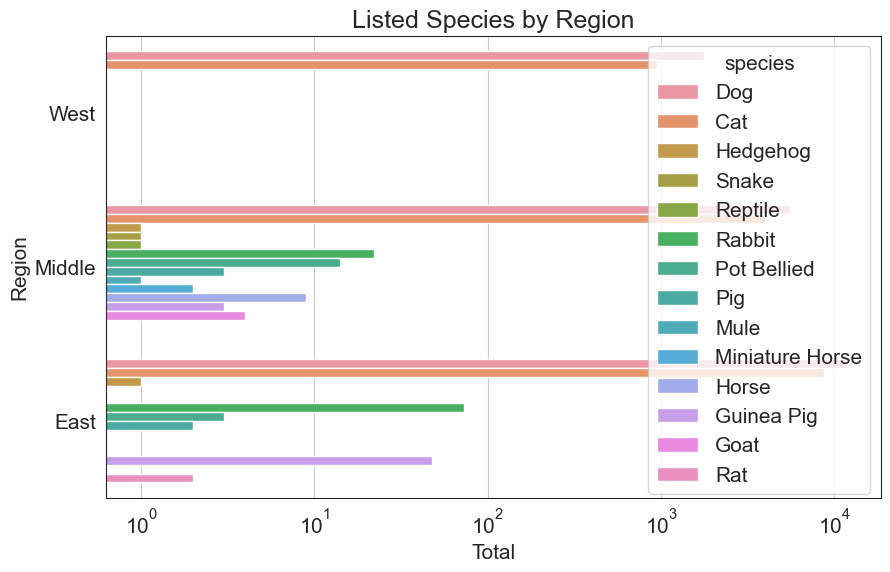

Mostly cats and dogs in most regions
West - Only dogs an cats
Middle - 13/14 Animals but mostly cats and dogs and and some rabbits/pigs
East - 8/13 animals - Most of the rabits and Guinea pigs


In [49]:
# Are certain regions more likely to list certain types of animals

# Create regional dataframe with listed/adopted counts and adoption rates by species
listed_group = df.groupby(['region', 'species'])['id'].count().reset_index(name='count_listed')
adopted_group = adopted.groupby(['region', 'species'])['id'].count().reset_index(name='count_adopted')

region_ar = pd.merge(listed_group, adopted_group, on=['region', 'species'], how='outer')
region_ar['count_adopted'] = region_ar['count_adopted'].fillna(0)

region_ar['Adoption Rate %'] = round(region_ar['count_adopted'] / region_ar['count_listed'] * 100, 2)
region_ar = region_ar.sort_values('region', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='count_listed', y='region', hue='species', orient='h', data=region_ar)

plt.title('Listed Species by Region')
plt.xlabel('Total')
plt.ylabel('Region')
plt.grid(axis='x')
plt.xscale('log')
plt.show()

print('Mostly cats and dogs in most regions')
print('West - Only dogs an cats')
print('Middle - 13/14 Animals but mostly cats and dogs and and some rabbits/pigs')
print('East - 8/13 animals - Most of the rabits and Guinea pigs')

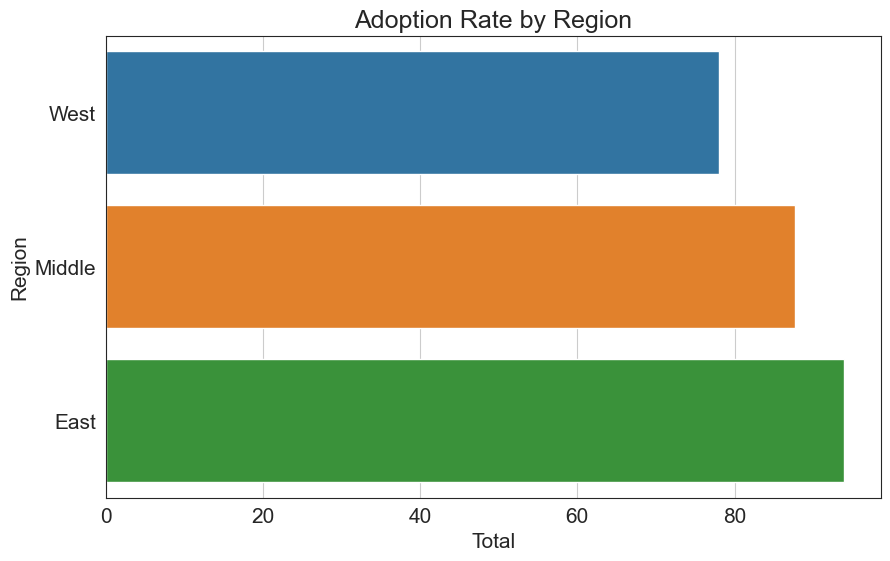

East Tennessee has the highest adoption rate at 93.91%


,region,count_listed,count_adopted,Adoption Rate %
2,West,2722,2122,77.96
1,Middle,9621,8442,87.75
0,East,20414,19171,93.91


In [50]:
# What is the adoption rate by region? Which region has the highest adoption rate?

listed_group = df.groupby('region')['id'].count().reset_index(name='count_listed')
adopted_group = adopted.groupby('region')['id'].count().reset_index(name='count_adopted')

region_ar = pd.merge(listed_group, adopted_group, on='region', how='outer')
region_ar['count_adopted'] = region_ar['count_adopted'].fillna(0)

region_ar['Adoption Rate %'] = round(region_ar['count_adopted'] / region_ar['count_listed'] * 100, 2)
region_ar = region_ar.sort_values('region', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Adoption Rate %', y='region', data=region_ar)

plt.title('Adoption Rate by Region')
plt.xlabel('Total')
plt.ylabel('Region')
plt.grid(axis='x')

plt.show()

print('East Tennessee has the highest adoption rate at 93.91%')
region_ar

In [51]:
listed_group = df.groupby(['region', 'city'])['id'].count().reset_index(name='count_listed')
adopted_group = adopted.groupby(['region', 'city'])['id'].count().reset_index(name='count_adopted')

region_ar = pd.merge(listed_group, adopted_group, on=['region', 'city'], how='outer')
region_ar['count_adopted'] = region_ar['count_adopted'].fillna(0)

region_ar['Adoption Rate %'] = round(region_ar['count_adopted'] / region_ar['count_listed'] * 100, 2)
region_ar = region_ar.sort_values('region', ascending=False)

region_ar

#plt.figure(figsize=(10, 6))
#sns.barplot(x='Adoption Rate %', y='region', data=region_ar)

#plt.title('Adoption Rate by Region')
#plt.xlabel('Total')
#plt.ylabel('Region')
#plt.grid(axis='x')

#plt.show()

,region,city,count_listed,count_adopted,Adoption Rate %
148,West,Savannah,28,16.0,57.14
135,West,Greenfield,59,15.0,25.42
123,West,Arlington,56,44.0,78.57
124,West,Atoka,11,1.0,9.09
126,West,Brownsville,78,74.0,94.87
...,...,...,...,...,...
39,East,New Tazewell,584,584.0,100.00
38,East,Mountain City,104,60.0,57.69
36,East,Maynardville,559,558.0,99.82
35,East,Maryville,91,44.0,48.35


In [52]:
df

,id,organization_id,url,type,species,age,gender,size,coat,tags,name,description,status,status_changed_at,published_at,breeds.primary,breeds.secondary,breeds.mixed,breeds.unknown,colors.primary,colors.secondary,colors.tertiary,attributes.spayed_neutered,attributes.house_trained,attributes.declawed,attributes.special_needs,attributes.shots_current,environment.children,environment.dogs,environment.cats,zip,published_date,status_change_date,adoption_time,month_published,day_published,year_published,time_published,month_status_change,day_status_change,year_status_change,time_status_change,lat,lng,city,state_name,population,density,county_name,region,status_change_dow,status_change_hour,published_dow,published_hour,season
0,70203376.0,TN90,https://www.petfinder.com/cat/ac-25055-7020337...,Cat,Cat,Young,Male,Medium,<NA>,<NA>,Ac 25055,<NA>,adopted,2023-12-31 10:03:59+00:00,2023-12-31 10:03:58+00:00,Domestic Short Hair,<NA>,False,False,Unknown Color,<NA>,<NA>,False,False,0.0,False,False,<NA>,<NA>,<NA>,37745.0,2023-12-31,2023-12-31,0.0,12.0,31.0,2023.0,10:03:58,12.0,31.0,2023.0,10:03:59,36.27840,-82.82631,Greeneville,Tennessee,20852.0,66.0,Greene,East,Sunday,10,Sunday,10,Winter
1,70203375.0,TN90,https://www.petfinder.com/cat/ac-25035-7020337...,Cat,Cat,Young,Female,Medium,<NA>,<NA>,Ac 25035,<NA>,adopted,2023-12-31 10:03:57+00:00,2023-12-31 10:03:56+00:00,Domestic Short Hair,<NA>,False,False,Unknown Color,<NA>,<NA>,False,False,0.0,False,False,<NA>,<NA>,<NA>,37745.0,2023-12-31,2023-12-31,0.0,12.0,31.0,2023.0,10:03:56,12.0,31.0,2023.0,10:03:57,36.27840,-82.82631,Greeneville,Tennessee,20852.0,66.0,Greene,East,Sunday,10,Sunday,10,Winter
2,70203356.0,TN95,https://www.petfinder.com/cat/germaine-7020335...,Cat,Cat,Adult,Female,Small,<NA>,<NA>,Germaine,"Meet Germaine, a delightful and talkative fema...",adopted,2023-12-31 10:02:56+00:00,2023-12-31 10:02:54+00:00,Domestic Short Hair,<NA>,False,False,Unknown Color,<NA>,<NA>,True,True,0.0,False,False,True,<NA>,True,37617.0,2023-12-31,2023-12-31,0.0,12.0,31.0,2023.0,10:02:54,12.0,31.0,2023.0,10:02:56,36.53155,-82.37248,Blountville,Tennessee,14519.0,96.0,Sullivan,East,Sunday,10,Sunday,10,Winter
3,70199892.0,TN484,https://www.petfinder.com/cat/sega-gentle-and-...,Cat,Cat,Young,Female,Medium,Medium,"Friendly, Gentle, Playful, Affectionate",Sega - Gentle & Cuddly,Sega is a gorgeous fluffy orange and white gir...,adopted,2023-12-31 23:52:55+00:00,2023-12-30 22:01:46+00:00,Domestic Medium Hair,<NA>,False,False,Orange & White,<NA>,<NA>,True,True,0.0,False,True,True,True,True,37115.0,2023-12-30,2023-12-31,1.0,12.0,30.0,2023.0,22:01:46,12.0,31.0,2023.0,23:52:55,36.25444,-86.69636,Madison,Tennessee,41926.0,754.4,Davidson,Middle,Sunday,23,Saturday,22,Winter
4,70194247.0,TN95,https://www.petfinder.com/cat/charlotte-701942...,Cat,Cat,Young,Female,Small,<NA>,<NA>,Charlotte,"Hey, I&amp;#39;m Charlotte--a young cat with s...",adopted,2023-12-31 10:02:54+00:00,2023-12-30 10:08:11+00:00,Domestic Short Hair,Siamese,True,False,Unknown Color,<NA>,<NA>,True,True,0.0,False,False,<NA>,<NA>,<NA>,37617.0,2023-12-30,2023-12-31,1.0,12.0,30.0,2023.0,10:08:11,12.0,31.0,2023.0,10:02:54,36.53155,-82.37248,Blountville,Tennessee,14519.0,96.0,Sullivan,East,Sunday,10,Saturday,10,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32752,69930096.0,TN48,https://www.petfinder.com/small-furry/junior-6...,Small & Furry,Guinea Pig,Young,Male,Medium,<NA>,<NA>,Junior,Junior is a 1 year old guinea pig who is looki...,adoptable,2023-12-06 10:07:36+00:00,2023-12-06 10:07:34+00:00,Guinea Pig,<NA>,False,False,Unknown Color,<NA>,<NA>,False,False,NaN,False,False,<NA>,<NA>,<NA>,37334.0,2023-12-06,2023-12-06,0.0,12.0,6.0,2023.0,10:07:34,12.0,6.0,2023.0,10:07:36,35.16532,-86.57966,Fayetteville,Tennessee,24051.0,36.5,Lincoln,Middle,Wednesday,10,Wednesday,10,Winter
32753,6965156